In [1]:
# Standard Libraries
import os # operating system dependent functionality
from collections import Counter # counting elements in an iterable

# External Libraries
import numpy as np # numerical operations on data arrays and matrices
import pandas as pd # data manipulation and analysis
import matplotlib.pyplot as plt # plotting and visualizations
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors

# Bioinformatics and Data Analysis 
import anndata # handling annotated data, particularly in genomics
import scanpy as sc # single-cell RNA-seq data analysis
import scipy # scientific and technical computations

# Test Specific Libraries
from sklearn.decomposition import PCA, FastICA
import cell2sentence as cs
from cell2sentence import tasks, CSData, CSModel
from cell2sentence.prompt_formatter import PromptFormatter
import ot
import cinemaot as co

# Huggingface
import torch
from transformers import AutoModelForCausalLM
from datasets import load_from_disk

# Confusion Matrix visualization
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
import seaborn as sns

from scipy.stats import spearmanr

/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load processed AnnData objects for human and mouse cells
human_restricted = anndata.read_h5ad("/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_data/human_pancreas_preprocessed_log10_homolog_intersected_adata.h5ad")
mouse_restricted = anndata.read_h5ad("/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_data/mouse_pancreas_preprocessed_log10_homolog_intersected_adata.h5ad")

In [3]:
human_restricted

AnnData object with n_obs × n_vars = 8569 × 12113
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ensembl_id'

In [4]:
human_restricted.X.data[:10]  # Already preprocessed, no need to filter/normalize

array([0.08864673, 0.08864673, 0.16223046, 0.22513437, 0.08864673,
       0.2800693 , 0.16223046, 0.08864673, 0.16223046, 0.32882914],
      dtype=float32)

In [5]:
mouse_restricted

AnnData object with n_obs × n_vars = 1886 × 12113
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ensembl_id'

In [6]:
human_restricted.obs.head()

,cell_barcodes,cell_manual_ids,cell_types,batch_sample,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
human1_lib1.final_cell_0001,GATGACGGAC-GGTGGGAT,human1_lib1.final_cell_0001,acinar,GSM2230757_human1_umifm_counts,3526,3526,22412.0,0.0,0.0
human1_lib1.final_cell_0002,GAGCGTTGCT-ACCTTCTT,human1_lib1.final_cell_0002,acinar,GSM2230757_human1_umifm_counts,4201,4201,27953.0,0.0,0.0
human1_lib1.final_cell_0003,CTTACGGG-CCATTACT,human1_lib1.final_cell_0003,acinar,GSM2230757_human1_umifm_counts,2119,2118,16894.0,0.0,0.0
human1_lib1.final_cell_0004,GATGTACACG-TTAAACTG,human1_lib1.final_cell_0004,acinar,GSM2230757_human1_umifm_counts,2956,2956,19300.0,0.0,0.0
human1_lib1.final_cell_0005,GAGATTGCGA-GTCGTCGT,human1_lib1.final_cell_0005,acinar,GSM2230757_human1_umifm_counts,2715,2715,15067.0,0.0,0.0


In [7]:
# Ensure organism key is present for both human and mouse
if 'organism' not in human_restricted.obs:
    human_restricted.obs['organism'] = 'Homo sapiens'
if 'organism' not in mouse_restricted.obs:
    mouse_restricted.obs['organism'] = 'Mus musculus'

# Ensure cell_tyope key is present - slightly misworded
if 'cell_type' not in human_restricted.obs:
    human_restricted.obs['cell_type'] = human_restricted.obs['cell_types']
if 'cell_type' not in mouse_restricted.obs:
    mouse_restricted.obs['cell_type'] = mouse_restricted.obs['cell_types']

human_restricted.obs['cell_type'] = [x.lower() for x in human_restricted.obs['cell_type']]
mouse_restricted.obs['cell_type'] = [x.lower() for x in mouse_restricted.obs['cell_type']]

# Add species labels
human_restricted.obs['species'] = 'human'
mouse_restricted.obs['species'] = 'mouse'

In [8]:
human_restricted.obs.head()

,cell_barcodes,cell_manual_ids,cell_types,batch_sample,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,organism,cell_type,species
human1_lib1.final_cell_0001,GATGACGGAC-GGTGGGAT,human1_lib1.final_cell_0001,acinar,GSM2230757_human1_umifm_counts,3526,3526,22412.0,0.0,0.0,Homo sapiens,acinar,human
human1_lib1.final_cell_0002,GAGCGTTGCT-ACCTTCTT,human1_lib1.final_cell_0002,acinar,GSM2230757_human1_umifm_counts,4201,4201,27953.0,0.0,0.0,Homo sapiens,acinar,human
human1_lib1.final_cell_0003,CTTACGGG-CCATTACT,human1_lib1.final_cell_0003,acinar,GSM2230757_human1_umifm_counts,2119,2118,16894.0,0.0,0.0,Homo sapiens,acinar,human
human1_lib1.final_cell_0004,GATGTACACG-TTAAACTG,human1_lib1.final_cell_0004,acinar,GSM2230757_human1_umifm_counts,2956,2956,19300.0,0.0,0.0,Homo sapiens,acinar,human
human1_lib1.final_cell_0005,GAGATTGCGA-GTCGTCGT,human1_lib1.final_cell_0005,acinar,GSM2230757_human1_umifm_counts,2715,2715,15067.0,0.0,0.0,Homo sapiens,acinar,human


Data is already processed, no need to filter or normalize

Using Preprocessed data to embed cells

In [9]:
c2s_save_dir = "/home/dor3/scratch/C2S_Files/c2s_api_testing"  # C2S dataset will be saved into this directory
human_c2s_save_name = "human_pancreas_tissue_c2s_embeddings_cinema_ot"  # This will be the name of our C2S dataset on disk
mouse_c2s_save_name = "mouse_pancreas_tissue_c2s_embeddings_cinema_ot"  # This will be the name of our C2S dataset on disk

In [10]:
# arrow_dir='./data/'
# # ensure the directory for Arrow datasets exists
# os.makedirs(arrow_dir, exist_ok=True)

# # paths to Arrow datasets
# arrow_path_human = os.path.join(arrow_dir, 'human_arrow')
# arrow_path_mouse = os.path.join(arrow_dir, 'mouse_arrow')

# convert AnnData to Arrow format and save
'''# Create CSData object
arrow_ds, vocabulary = cs.CSData.adata_to_arrow(
    adata=adata, 
    random_state=SEED, 
    sentence_delimiter=' ',
    label_col_names=adata_obs_cols_to_keep
)'''
human_arrow_ds, human_vocab = CSData.adata_to_arrow(
    adata=human_restricted, 
    random_state=1234, 
    sentence_delimiter=' ',
    label_col_names=['cell_type', 'organism']  # NOTE: need this to keep 'organism' column in arrow dataset!
)

mouse_arrow_ds, mouse_vocab = CSData.adata_to_arrow(
    adata=mouse_restricted,
    random_state=1234, 
    sentence_delimiter=' ',
    label_col_names=['cell_type', 'organism']  # NOTE: need this to keep 'organism' column in arrow dataset!
)

WARN: more variables (12113) than observations (8569)... did you mean to transpose the object (e.g. adata.T)?
WARN: more variables (12113) than observations (8569), did you mean to transpose the object (e.g. adata.T)?
100%|██████████| 8569/8569 [00:08<00:00, 1021.71it/s]
WARN: more variables (12113) than observations (1886)... did you mean to transpose the object (e.g. adata.T)?
WARN: more variables (12113) than observations (1886), did you mean to transpose the object (e.g. adata.T)?
100%|██████████| 1886/1886 [00:01<00:00, 1132.75it/s]


In [11]:
human_arrow_ds  # NOTE: notice how 'organism' shows up now in the columns

Dataset({
    features: ['cell_name', 'cell_sentence', 'cell_type', 'organism'],
    num_rows: 8569
})

In [12]:
mouse_arrow_ds

Dataset({
    features: ['cell_name', 'cell_sentence', 'cell_type', 'organism'],
    num_rows: 1886
})

In [13]:
human_csdata = cs.CSData.csdata_from_arrow(
    arrow_dataset=human_arrow_ds, 
    vocabulary=human_vocab,
    save_dir=c2s_save_dir,
    save_name=human_c2s_save_name,
    dataset_backend="arrow"
)

Saving the dataset (1/1 shards): 100%|██████████| 8569/8569 [00:00<00:00, 34165.87 examples/s]


In [14]:
mouse_csdata = cs.CSData.csdata_from_arrow(
    arrow_dataset=mouse_arrow_ds, 
    vocabulary=mouse_vocab,
    save_dir=c2s_save_dir,
    save_name=mouse_c2s_save_name,
    dataset_backend="arrow"
)

Saving the dataset (1/1 shards): 100%|██████████| 1886/1886 [00:00<00:00, 32921.56 examples/s]


The tasks.embed_cells function will create the 'cell sentence' key in the dataset

In [15]:
# Define CSModel object
# Huggingface link: https://huggingface.co/vandijklab/C2S-Pythia-410m-diverse-single-and-multi-cell-tasks

# Pull model from web, save model to disk
model_path = "vandijklab/C2S-Pythia-410m-diverse-single-and-multi-cell-tasks"
save_dir = "/home/dor3/palmer_scratch/C2S_Files_Daphne/c2s_api_testing/csmodel_tutorial_2"
save_name = "cell_embedding_prediction_pythia_410M_1"
csmodel = cs.CSModel(
    model_name_or_path=model_path,
    save_dir=save_dir,
    save_name=save_name
)

Using device: cpu


In [16]:
# Identify parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Define the directory to save the embeddings
embedded_cells_dir = os.path.join(parent_dir, "Embedded_Cells")
os.makedirs(embedded_cells_dir, exist_ok=True)

# Define file paths for human and mouse embeddings
human_embedding_path = os.path.join(embedded_cells_dir, "human_embeddings.npy")
mouse_embedding_path = os.path.join(embedded_cells_dir, "mouse_embeddings.npy")

# Function to save embeddings
def save_embeddings(embedding, filepath):
    np.save(filepath, embedding)
    print(f"Saved embeddings to {filepath}")

# Function to load embeddings
def load_embeddings(filepath):
    embedding = np.load(filepath)
    print(f"Loaded embeddings from {filepath}")
    return embedding


In [17]:
# Check if embeddings already exist
if os.path.exists(human_embedding_path): 
    # Load the embeddings from files
    embedded_human_cells = load_embeddings(human_embedding_path)

else:
    # Perform embedding using the GPU (with Cell2Sentence)
    # Embed human cells
    embedded_human_cells = tasks.embed_cells(
        csdata=human_csdata,
        csmodel=csmodel,
        n_genes=1000,
        inference_batch_size=1
    )
    # Save the embeddings to files so we don't need to use GPU next time
    save_embeddings(embedded_human_cells, human_embedding_path)

if os.path.exists(mouse_embedding_path):
    # Load the embeddings from files
    embedded_mouse_cells = load_embeddings(mouse_embedding_path)
else:
    # Perform embedding using the GPU (with Cell2Sentence)
    # Embed mouse cells
    embedded_mouse_cells = tasks.embed_cells(
        csdata=mouse_csdata,
        csmodel=csmodel,
        n_genes=1000,
        inference_batch_size=1
    )
    # Save the embeddings to files so we don't need to use GPU next time
    save_embeddings(embedded_mouse_cells, mouse_embedding_path)

Loaded embeddings from /vast/palmer/home.mccleary/dor3/cell2sentence/cross_species/Embedded_Cells/human_embeddings.npy
Loaded embeddings from /vast/palmer/home.mccleary/dor3/cell2sentence/cross_species/Embedded_Cells/mouse_embeddings.npy


In [18]:
embedded_human_cells.shape

(8569, 1024)

In [19]:
human_c2s_embed_matrix = embedded_human_cells  # This should be shape [num_cells, num_genes]
# Define an observation dataframe
obs_df = human_restricted.obs.copy()  # Just copy obs df from original anndata object, since cells are the same

# Define a variables dataframe
col_names = ["dim_{}".format(idx) for idx in range(human_c2s_embed_matrix.shape[1])]
var_df = pd.DataFrame({
    "col_names": col_names
}, index=col_names)

# Define AnnData object with C2S embeddings
human_adata = anndata.AnnData(X=human_c2s_embed_matrix, obs=obs_df, var=var_df)

In [20]:
mouse_c2s_embed_matrix = embedded_mouse_cells  # This should be shape [num_cells, num_genes]
# Define an observation dataframe
obs_df = mouse_restricted.obs.copy()  # Just copy obs df from original anndata object, since cells are the same

# Define a variables dataframe
col_names = ["dim_{}".format(idx) for idx in range(mouse_c2s_embed_matrix.shape[1])]
var_df = pd.DataFrame({
    "col_names": col_names
}, index=col_names)

# Define AnnData object with C2S embeddings
mouse_adata = anndata.AnnData(X=mouse_c2s_embed_matrix, obs=obs_df, var=var_df)

In [21]:
# Combine the datasets to perform OT
combined_adata = anndata.concat([human_adata, mouse_adata], merge='same')


In [22]:
combined_adata

AnnData object with n_obs × n_vars = 10455 × 1024
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'organism', 'cell_type', 'species'
    var: 'col_names'

In [23]:
sc.pp.highly_variable_genes(combined_adata, subset=False,n_top_genes=2000,batch_key='batch_sample')
sc.tl.pca(combined_adata,use_highly_variable=True)
sc.external.pp.harmony_integrate(combined_adata,'batch_sample',basis='X_pca',adjusted_basis='X_pca_harmony_library')

/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:218: RuntimeWarning: invalid value encountered in log
/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:279: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:218: RuntimeWarning: invalid value encountered in log
/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:279: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/preprocessing/_highly_v

In [24]:
combined_adata

AnnData object with n_obs × n_vars = 10455 × 1024
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'organism', 'cell_type', 'species'
    var: 'col_names', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'pca'
    obsm: 'X_pca', 'X_pca_harmony_library'
    varm: 'PCs'

In [25]:
sc.pp.neighbors(combined_adata, use_rep="X_pca_harmony_library")

In [26]:
combined_adata

AnnData object with n_obs × n_vars = 10455 × 1024
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'organism', 'cell_type', 'species'
    var: 'col_names', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'pca', 'neighbors'
    obsm: 'X_pca', 'X_pca_harmony_library'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [27]:

# Run PCA on the combined AnnData
#sc.pp.pca(combined_adata)

In [28]:
cf_unweighted, ot_unweighted, de_unweighted = co.cinemaot.cinemaot_unweighted(
    adata=combined_adata,
    obs_label='species', 
    ref_label='human', 
    expr_label='mouse',
    mode='parametric',
    thres=0.5,
    smoothness=1e-5,
    eps=1e-3)


In [29]:
ot_unweighted

array([[1.59014329e-11, 3.96647558e-08, 4.04946731e-11, ...,
        3.96992861e-09, 2.80281854e-08, 4.40478396e-10],
       [5.32619472e-11, 1.21885182e-10, 1.84961638e-11, ...,
        3.34863701e-10, 1.90817376e-11, 1.85310836e-13],
       [5.73261894e-10, 1.67502340e-10, 2.33207817e-08, ...,
        5.77545592e-10, 6.70083722e-10, 3.85363844e-10],
       ...,
       [2.33896135e-11, 3.56385600e-15, 6.78817667e-10, ...,
        6.83822457e-09, 9.30138895e-09, 5.31451669e-11],
       [8.50268231e-14, 4.40841749e-16, 3.31239719e-10, ...,
        1.62990377e-10, 1.33917639e-10, 2.21939258e-14],
       [1.57523225e-08, 1.76036542e-19, 1.25475168e-11, ...,
        9.19431990e-10, 3.18840385e-12, 1.68750607e-09]])

In [30]:
# Display results
print("Confounder (cf) shape:", cf_unweighted.shape)
print("Optimal Transport (ot) shape:", ot_unweighted.shape)
print("Differential Expression (de) shape:", de_unweighted.shape)


Confounder (cf) shape: (10455, 19)
Optimal Transport (ot) shape: (8569, 1886)
Differential Expression (de) shape: (8569, 1024)


In [31]:
# Extract paired indices based on the optimal transport plan
paired_indices = []
for human_idx in range(ot_unweighted.shape[0]):
    if np.sum(ot_unweighted[human_idx]) > 0:
        mouse_idx = np.argmax(ot_unweighted[human_idx])
        paired_indices.append((human_idx, mouse_idx))

In [32]:
if not np.isnan(ot_unweighted).any():
    # Extract paired indices based on the optimal transport plan
    paired_indices = []
    for human_idx in range(ot_unweighted.shape[0]):
        if np.sum(ot_unweighted[human_idx]) > 0:
            mouse_idx = np.argmax(ot_unweighted[human_idx])
            paired_indices.append((human_idx, mouse_idx))

    # Print paired indices
    print("Optimal Transport Pairs (human_idx, mouse_idx):")
    for human_idx, mouse_idx in paired_indices:
        print(f"Human cell {human_idx} paired with Mouse cell {mouse_idx}")


Optimal Transport Pairs (human_idx, mouse_idx):
Human cell 0 paired with Mouse cell 575
Human cell 1 paired with Mouse cell 1760
Human cell 2 paired with Mouse cell 166
Human cell 3 paired with Mouse cell 27
Human cell 4 paired with Mouse cell 35
Human cell 5 paired with Mouse cell 166
Human cell 6 paired with Mouse cell 1552
Human cell 7 paired with Mouse cell 150
Human cell 8 paired with Mouse cell 1065
Human cell 9 paired with Mouse cell 1359
Human cell 10 paired with Mouse cell 485
Human cell 11 paired with Mouse cell 867
Human cell 12 paired with Mouse cell 299
Human cell 13 paired with Mouse cell 657
Human cell 14 paired with Mouse cell 1552
Human cell 15 paired with Mouse cell 278
Human cell 16 paired with Mouse cell 86
Human cell 17 paired with Mouse cell 461
Human cell 18 paired with Mouse cell 578
Human cell 19 paired with Mouse cell 1609
Human cell 20 paired with Mouse cell 1348
Human cell 21 paired with Mouse cell 522
Human cell 22 paired with Mouse cell 1715
Human cell 23 

In [33]:
# Create the "plots" directory if it doesn't exist
plots_dir = "plots"
os.makedirs(plots_dir, exist_ok=True)

/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


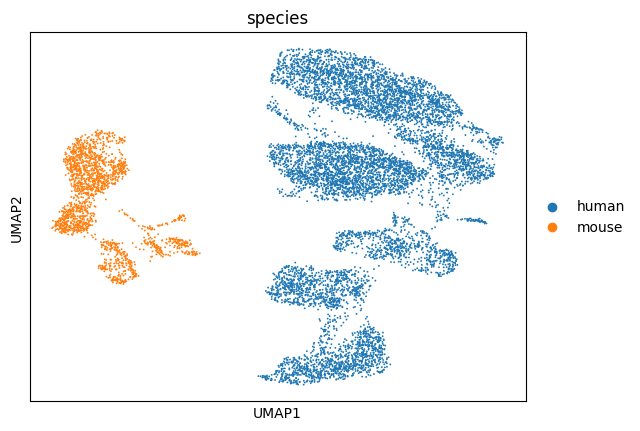

UMAP plot saved to plots/umap_harmonized_species.png


In [34]:
# Optional: Visualize the optimal transport pairs on UMAP
sc.pp.neighbors(combined_adata, use_rep='X_pca')
sc.tl.umap(combined_adata)

# Visualize UMAP
umap_species_plot_path = os.path.join(plots_dir, "umap_harmonized_species.png")
fig = sc.pl.umap(combined_adata, color=['species'], return_fig=True, s=7)
plt.show()

# Save the plot using matplotlib
fig.savefig(umap_species_plot_path, dpi=300, bbox_inches='tight')
plt.close()  # Close the plot to free memory

# Print confirmation
print(f"UMAP plot saved to {umap_species_plot_path}")


/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


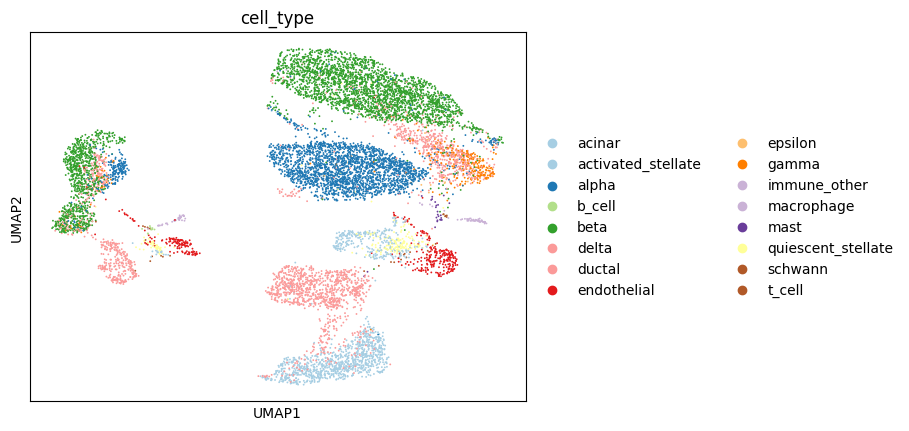

UMAP plot saved to plots/umap_harmonized_cell_type.png


In [35]:

# Optional: Visualize the optimal transport pairs on UMAP
sc.pp.neighbors(combined_adata, use_rep='X_pca')
sc.tl.umap(combined_adata)

# Visualize UMAP
umap_cell_type_plot_path = os.path.join(plots_dir, "umap_harmonized_cell_type.png")
fig = sc.pl.umap(combined_adata, color=['cell_type'], return_fig=True, palette="Paired", s=7)
plt.show()

# Save the plot using matplotlib
fig.savefig(umap_cell_type_plot_path, dpi=300, bbox_inches='tight')
plt.close()  # Close the plot to free memory

# Print confirmation
print(f"UMAP plot saved to {umap_cell_type_plot_path}")

In [36]:
def plot_joint_umap_with_pairs(
    human_mouse_joint_adata,
    num_human_cells,
    paired_indices,
    color_label,
    save_path,
    title,
    cell_type=None,
    adata_human=None,
    adata_mouse=None,
    filter_by_human=True  # if True, shows which mouse cells all human cells map to, else vice versa
):
    """
    Create a joint UMAP of human and mouse AnnData objects and plot the lines connecting paired cells.

    Parameters:
    - human_mouse_adata: AnnData object for human and mouse cells.
    - paired_indices: List of tuples (human_index, mouse_index) of paired cells.
    - color_label: The column in `obs` to color by.
    - save_path: Path to save the plot.
    - cell_type: (Optional) Filter pairs by specific cell type.
    - adata_human: AnnData object for human cells.
    - adata_mouse: AnnData object for mouse cells.
    - filter_by_human: True to filter by human cell type, False to filter by mouse cell type.
    """
    # Ensure the "plots" directory exists
    plots_dir = os.path.join(os.getcwd(), "plots")
    os.makedirs(plots_dir, exist_ok=True)
    
    # Construct the full save path
    full_save_path = os.path.join(plots_dir, save_path)
    
    # Ensure UMAP is computed and stored in the AnnData object
    if 'X_umap' not in human_mouse_joint_adata.obsm:
        sc.pp.neighbors(human_mouse_joint_adata)
        sc.tl.umap(human_mouse_joint_adata)
    
    if color_label=='species':
        # Plot the UMAP
        sc.pl.umap(
            human_mouse_joint_adata, 
            color=color_label, 
            show=False, 
            s=7,
            title=title,
        )
    else:
        # Plot the UMAP
        sc.pl.umap(
            human_mouse_joint_adata, 
            color=color_label, 
            show=False, 
            palette="Paired",
            s=7,
            title=title,
        )

    # Extract the UMAP coordinates
    umap_human = human_mouse_joint_adata.obsm['X_umap'][:num_human_cells, :]
    umap_mouse = human_mouse_joint_adata.obsm['X_umap'][num_human_cells:, :]

    # Filter the paired indices based on the specified cell type, if provided
    if cell_type:
        if filter_by_human:
            human_cell_type_mask = adata_human.obs['cell_types'] == cell_type
            filtered_pairs = [
                (human_idx, mouse_idx) for human_idx, mouse_idx in paired_indices
                if human_cell_type_mask[human_idx]
            ]
        else:
            mouse_cell_type_mask = adata_mouse.obs['cell_types'] == cell_type
            filtered_pairs = [
                (human_idx, mouse_idx) for human_idx, mouse_idx in paired_indices
                if mouse_cell_type_mask[mouse_idx]
            ]
    else:
        # Use all pairs if no cell type is specified
        filtered_pairs = paired_indices

    # Plot lines connecting paired human and mouse cells
    for human_idx, mouse_idx in filtered_pairs:
        # Get the UMAP coordinates of the paired human and mouse cells
        human_coord = umap_human[human_idx]
        mouse_coord = umap_mouse[mouse_idx]
        
        # Plot a light gray line connecting the paired cells
        plt.plot([human_coord[0], mouse_coord[0]], 
                 [human_coord[1], mouse_coord[1]], 
                 color='lightgray', linewidth=0.6, alpha=0.2, linestyle="--")

    # Save the plot
    plt.savefig(full_save_path, facecolor="white", bbox_inches="tight", dpi=300)
    plt.show()
    plt.close()

    # Print confirmation
    print(f"Plot saved to {full_save_path}")

/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


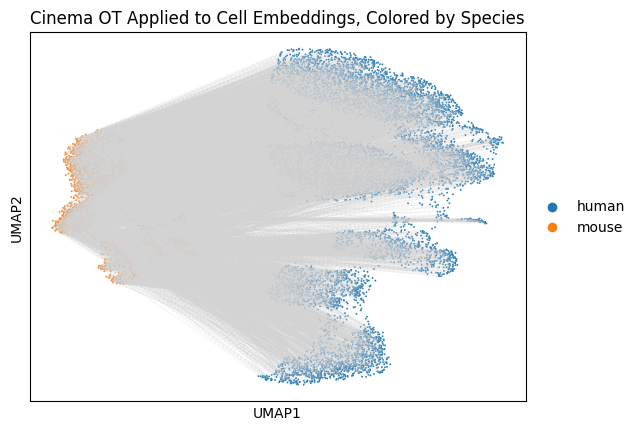

Plot saved to /vast/palmer/home.mccleary/dor3/cell2sentence/cross_species/Cinema_OT_on_Cell_Embeddings/plots/cinema_ot_paired_harmonized_cell_embeddings_species.png


In [37]:
color_label='species'
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=combined_adata, 
    num_human_cells=human_adata.shape[0],
    paired_indices=paired_indices, 
    color_label=color_label, 
    save_path="cinema_ot_paired_harmonized_cell_embeddings_species.png", 
    title=f"Cinema OT Applied to Cell Embeddings, Colored by {str.capitalize(color_label)}",
    adata_human=human_adata, 
    adata_mouse=mouse_adata
)

/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


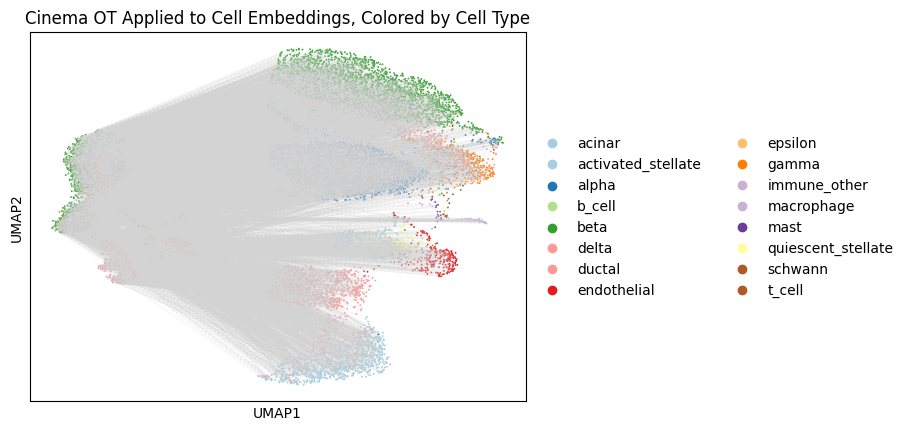

Plot saved to /vast/palmer/home.mccleary/dor3/cell2sentence/cross_species/Cinema_OT_on_Cell_Embeddings/plots/cinema_ot_paired_cell_harmonized_embeddings_cell_type.png


In [38]:
color_label='cell_type'
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=combined_adata, 
    num_human_cells=human_adata.shape[0],
    paired_indices=paired_indices, 
    color_label=color_label, 
    save_path="cinema_ot_paired_cell_harmonized_embeddings_cell_type.png", 
    title=f"Cinema OT Applied to Cell Embeddings, Colored by Cell Type",
    adata_human=human_adata, 
    adata_mouse=mouse_adata
)

In [39]:
# Extract true labels
human_labels = [x.lower() for x in human_adata.obs['cell_type'].values]
mouse_labels = [x.lower() for x in mouse_adata.obs['cell_type'].values]

# Create lists of labels based on paired indices
paired_human_labels = [human_labels[p[0]] for p in paired_indices]
paired_mouse_labels = [mouse_labels[p[1]] for p in paired_indices]

# Ensure both label sets are consistent but separated by species
unique_human_labels = np.unique(human_labels)
unique_mouse_labels = np.unique(mouse_labels)
print("Unique human labels:", unique_human_labels)
print("Unique mouse labels:", unique_mouse_labels)

# Combine unique labels for human and mouse separately
all_labels = np.union1d(unique_human_labels, unique_mouse_labels)

Unique human labels: ['acinar' 'activated_stellate' 'alpha' 'beta' 'delta' 'ductal'
 'endothelial' 'epsilon' 'gamma' 'macrophage' 'mast' 'quiescent_stellate'
 'schwann' 't_cell']
Unique mouse labels: ['activated_stellate' 'alpha' 'b_cell' 'beta' 'delta' 'ductal'
 'endothelial' 'gamma' 'immune_other' 'macrophage' 'quiescent_stellate'
 'schwann' 't_cell']


In [40]:
# Reorder all_labels to include common labels first (so our heatmap has a stronger diagonal)
def common_element(list1, list2):
    return [element for element in list1 if element in list2]
common_labels = common_element(unique_human_labels, unique_mouse_labels)
print(common_labels)

for i in all_labels:
    if i not in common_labels:
        common_labels.append(i)

all_labels = common_labels

['activated_stellate', 'alpha', 'beta', 'delta', 'ductal', 'endothelial', 'gamma', 'macrophage', 'quiescent_stellate', 'schwann', 't_cell']


In [41]:
cm_path = "/home/dor3/cell2sentence/cross_species/Cinema_OT_on_Cell_Embeddings/plots/cinema_ot_cell_embeddings_confusion_matrix.png"
# Generate confusion matrix with consistent labels
cm = confusion_matrix(paired_human_labels, paired_mouse_labels, labels=all_labels)

# Convert to DataFrame for better visualization
cm_df = DataFrame(cm, index=all_labels, columns=all_labels)

# Filter & calculate percentages
row_sums = cm_df.sum(axis=1)
col_sums = cm_df.sum(axis=0)
non_zero_rows = row_sums != 0
non_zero_cols = col_sums != 0
filtered_cm_df = cm_df.loc[non_zero_rows, non_zero_cols]
percentage_df = filtered_cm_df.div(filtered_cm_df.sum(axis=1), axis=0) * 100

# Custom annotation function - only show values above threshold
def annot_formatter(val):
    if val > 1:  # Only show values above 1%
        return f'{val:.1f}' if val < 10 else f'{val:.1f}'  # One decimal for small values
    return ''

# Create annotation matrix
annot_matrix = percentage_df.applymap(annot_formatter)

# Create a matplotlib figure and axis
plt.figure(figsize=(12, 10))

# Create custom colormap with better differentiation for small values
cmap = sns.color_palette("Greens", as_cmap=True)

heatmap = sns.heatmap(percentage_df,
            annot=annot_matrix,
            fmt='',
            cmap=cmap,
            linewidths=0.5,
            square=True,  # Make cells square
            cbar_kws={'label': 'Percentage (%)',
                     'shrink': .8},  # Customize colorbar
            annot_kws={'size': 8},  # Adjust annotation font size
            vmin=0,
            vmax=100)  # Fix color scale from 0 to 100%

# Get the colorbar and add gray outline
colorbar = heatmap.collections[0].colorbar
colorbar.outline.set_edgecolor('gray')
colorbar.outline.set_linewidth(0.7)

# Rotate axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Add descriptive title and labels
plt.title('Human-Mouse Cell Type Correspondence (%)', 
          pad=20,
          fontsize=16,
          fontweight='bold')

plt.xlabel('Mouse Cell Types', fontsize=15, labelpad=12)
plt.ylabel('Human Cell Types', fontsize=15, labelpad=12)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the plot using matplotlib
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
plt.close()  # Close the plot to free memory

# Print confirmation
print(f"Enhanced confusion matrix plot saved to {cm_path}")


Enhanced confusion matrix plot saved to /home/dor3/cell2sentence/cross_species/Cinema_OT_on_Cell_Embeddings/plots/cinema_ot_cell_embeddings_confusion_matrix.png


## Now we need to score the human-mouse mapping. 

### Raw Matching Score: This first metric calculates the percentage of human cells that are matched to mouse cells of the corresponding cell type, considering only shared cell types between species. While straightforward, this metric may be biased toward highly abundant cell types in the dataset (like beta cells), potentially overlooking the methods that find correspondences among a broader array of shared cell types.

In [42]:
''' Calculate Raw Matching Score '''

# Filter percentage_df to only include the rows and columns of the shared cells
filtered_df = filtered_cm_df.iloc[:11, :11]
filtered_df

# Sum of diagonal values (where row=column)
diagonal_sum = filtered_df.values[np.diag_indices(11)].sum()

# Sum of all values in dataframe  
total_sum = filtered_df.values.sum()

# Calculate raw matching score
raw_matching_score = diagonal_sum / float(total_sum)

### Balanced Cell Type Score: To address the potential bias in raw matching, we compute the average matching accuracy per cell type. This approach gives equal weight to each shared cell type regardless of its abundance in the dataset, providing a more balanced assessment of the method's performance across different cell populations.

In [43]:
''' Calculate Balanced Cell Type Score '''
# Filter confusion matrix of cell counts to only include rows and columns of the shared cell types
filtered_df = percentage_df.iloc[:11, :11]

# Get diagonal values 
diagonal = np.diag(percentage_df)

# Calculate mean of diagonal (average accuracy per cell type)
balanced_accuracy = (np.mean(diagonal) * .01)


### Gene Expression Correlation Score: This measure calculates the correlation between matched cells’ expression profiles for homologous genes. Higher correlation suggests better matching, regardless of cell type name. 

In [45]:
''' Calculate Gene Expression Correlation Score '''

def compute_correlation_score(human_data, mouse_data, paired_indices, homolog_genes):

   """
    Compute correlation-based score for matched cell pairs.
    
    Args:
    human_data: DataFrame of human gene expression (cells x genes)
    mouse_data: DataFrame of mouse gene expression (cells x genes)
    paired_indices: List of matched cell pairs from OT method's transport plan
    homolog_genes: List of homologous genes shared between species
    
    Returns:
    float: Average correlation score across all matched pairs

   """
   correlations = []
   for h_idx, m_idx in paired_indices:
       human_expr = human_data.iloc[h_idx][homolog_genes]
       mouse_expr = mouse_data.iloc[m_idx][homolog_genes]
       corr, _ = spearmanr(human_expr, mouse_expr)
       correlations.append(corr)
   
   return np.mean(correlations)

# Extract homologous genes from AnnData object
homolog_genes = human_restricted.var_names.tolist()

# Extract expression data
human_data = pd.DataFrame(human_restricted.X.toarray(),  # Convert sparse to dense
            columns=homolog_genes,
            index=human_restricted.obs_names)

mouse_data = pd.DataFrame(mouse_restricted.X.toarray(),  # Convert sparse to dense 
            columns=homolog_genes,
            index=mouse_restricted.obs_names)


In [46]:
gene_expression_correlation_score = compute_correlation_score(human_data, mouse_data, paired_indices, homolog_genes)

In [47]:
print(f"Raw matching score: {raw_matching_score}")
print(f"Balanced cell type score: {balanced_accuracy}")
print(f"Gene expression correlation score: {gene_expression_correlation_score}")

Raw matching score: 0.5289826236901446
Balanced cell type score: 0.3762393196451056
Gene expression correlation score: 0.19688075950211972


# Legacy code (no longer in use) below

In [54]:
cm_df

,activated_stellate,alpha,beta,delta,ductal,endothelial,gamma,macrophage,quiescent_stellate,schwann,t_cell,acinar,b_cell,epsilon,immune_other,mast
activated_stellate,75,0,20,7,16,43,1,1,97,24,0,0,0,0,0,0
alpha,0,898,803,296,166,44,99,0,12,1,5,0,0,0,2,0
beta,2,107,1818,221,251,47,22,0,52,2,1,0,2,0,0,0
delta,0,4,189,203,174,5,22,0,3,1,0,0,0,0,0,0
ductal,1,10,266,74,613,34,26,0,29,0,8,0,2,0,14,0
endothelial,0,0,3,0,3,242,0,0,3,0,0,0,0,0,1,0
gamma,0,13,102,97,24,0,17,0,1,1,0,0,0,0,0,0
macrophage,0,0,0,0,0,2,0,49,0,0,0,0,1,0,3,0
quiescent_stellate,10,0,34,8,5,42,0,0,71,2,1,0,0,0,0,0
schwann,0,0,4,0,6,2,0,0,1,0,0,0,0,0,0,0


In [57]:
for row in cm_df:
    print(row)
    print(cm_df.sum(axis=1))
    print()

activated_stellate
activated_stellate     284
alpha                 2326
beta                  2525
delta                  601
ductal                1077
endothelial            252
gamma                  255
macrophage              55
quiescent_stellate     173
schwann                 13
t_cell                   7
acinar                 958
b_cell                   0
epsilon                 18
immune_other             0
mast                    25
dtype: int64

alpha
activated_stellate     284
alpha                 2326
beta                  2525
delta                  601
ductal                1077
endothelial            252
gamma                  255
macrophage              55
quiescent_stellate     173
schwann                 13
t_cell                   7
acinar                 958
b_cell                   0
epsilon                 18
immune_other             0
mast                    25
dtype: int64

beta
activated_stellate     284
alpha                 2326
beta                  25

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


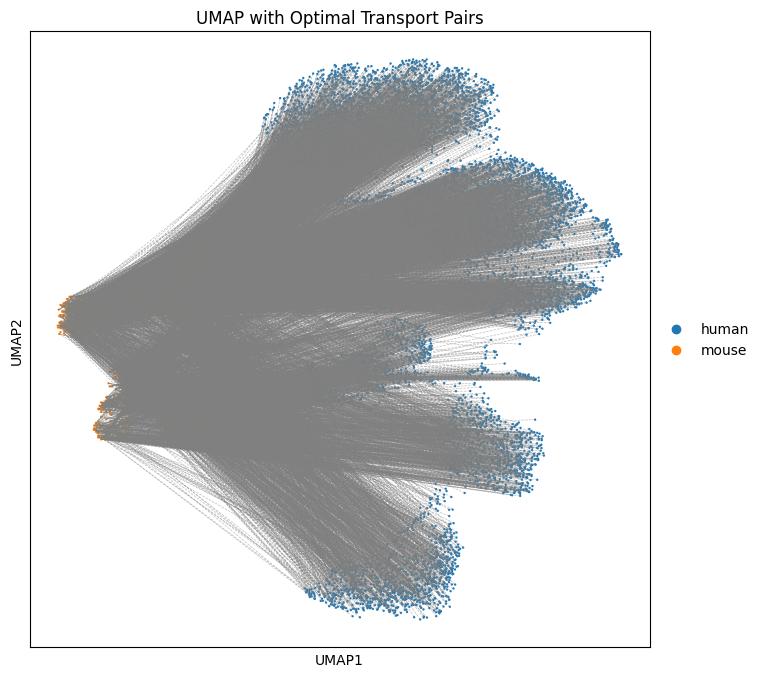

UMAP plot saved to plots/unweighted_cinemaot_umap_ot_pairs_species.png


In [30]:
# Optional: Plot optimal transport pairs
fig, ax = plt.subplots(figsize=(8, 8))
sc.pl.umap(combined_adata, color=['species'], ax=ax, show=False)
for human_idx in range(ot_unweighted.shape[0]):
    if np.sum(ot_unweighted[human_idx]) > 0:
        mouse_idx = np.argmax(ot_unweighted[human_idx])
        h = combined_adata.obsm['X_umap'][human_idx, :]
        m = combined_adata.obsm['X_umap'][mouse_idx + human_restricted.shape[0], :]
        plt.plot([h[0], m[0]], [h[1], m[1]], color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
plt.title('UMAP with Optimal Transport Pairs')
plt.show()

unweighted_umap_ot_pair_species_path = os.path.join(plots_dir, "unweighted_cinemaot_umap_ot_pairs_species.png")
# Save the plot using matplotlib
fig.savefig(unweighted_umap_ot_pair_species_path, dpi=300, bbox_inches='tight')
plt.close()  # Close the plot to free memory

# Print confirmation
print(f"UMAP plot saved to {unweighted_umap_ot_pair_species_path}")

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


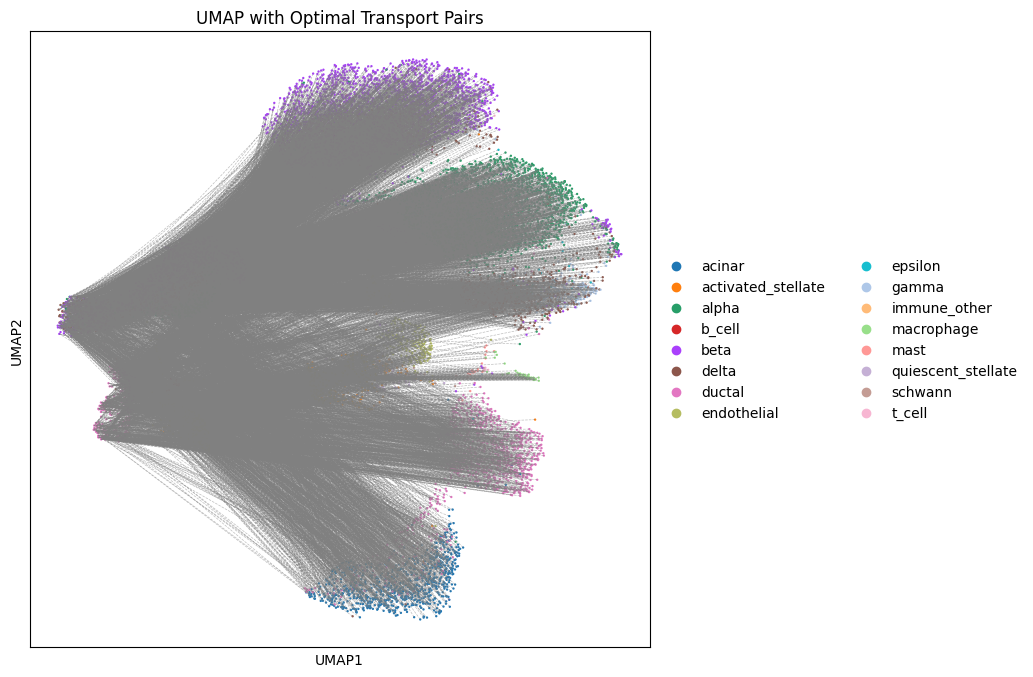

UMAP plot saved to plots/unweighted_cinemaot_umap_ot_pairs_cell_type.png


In [31]:
# Optional: Plot optimal transport pairs
fig, ax = plt.subplots(figsize=(8, 8))
sc.pl.umap(combined_adata, color=['cell_type'], ax=ax, show=False)
for human_idx in range(ot_unweighted.shape[0]):
    if np.sum(ot_unweighted[human_idx]) > 0:
        mouse_idx = np.argmax(ot_unweighted[human_idx])
        h = combined_adata.obsm['X_umap'][human_idx, :]
        m = combined_adata.obsm['X_umap'][mouse_idx + human_restricted.shape[0], :]
        plt.plot([h[0], m[0]], [h[1], m[1]], color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
plt.title('UMAP with Optimal Transport Pairs')
plt.show()

unweighted_umap_ot_pair_cell_type_path = os.path.join(plots_dir, "unweighted_cinemaot_umap_ot_pairs_cell_type.png")
# Save the plot using matplotlib
fig.savefig(unweighted_umap_ot_pair_cell_type_path, dpi=300, bbox_inches='tight')
plt.close()  # Close the plot to free memory

# Print confirmation
print(f"UMAP plot saved to {unweighted_umap_ot_pair_cell_type_path}")

In [32]:
# Extract true labels
human_labels = [x.lower() for x in human_restricted.obs['cell_type'].values]
mouse_labels = [x.lower() for x in mouse_restricted.obs['cell_type'].values]

# Create lists of labels based on paired indices
paired_human_labels = [human_labels[p[0]] for p in paired_indices]
paired_mouse_labels = [mouse_labels[p[1]] for p in paired_indices]

# Ensure both label sets are consistent but separated by species
unique_human_labels = np.unique(human_labels)
unique_mouse_labels = np.unique(mouse_labels)
print("Unique human labels:", unique_human_labels)
print("Unique mouse labels:", unique_mouse_labels)

# Combine unique labels for human and mouse separately
all_labels = np.union1d(unique_human_labels, unique_mouse_labels)

Unique human labels: ['acinar' 'activated_stellate' 'alpha' 'beta' 'delta' 'ductal'
 'endothelial' 'epsilon' 'gamma' 'macrophage' 'mast' 'quiescent_stellate'
 'schwann' 't_cell']
Unique mouse labels: ['activated_stellate' 'alpha' 'b_cell' 'beta' 'delta' 'ductal'
 'endothelial' 'gamma' 'immune_other' 'macrophage' 'quiescent_stellate'
 'schwann' 't_cell']


In [33]:
same_cell_type = [x for x in all_labels if x in unique_human_labels and x in unique_mouse_labels]
print("Shared cell types in human and mice:", same_cell_type)

Shared cell types in human and mice: ['activated_stellate', 'alpha', 'beta', 'delta', 'ductal', 'endothelial', 'gamma', 'macrophage', 'quiescent_stellate', 'schwann', 't_cell']


In [34]:
# Generate confusion matrix with consistent labels
cm_unweighted = confusion_matrix(paired_human_labels, paired_mouse_labels, labels=all_labels)

# Convert to DataFrame for better visualization
cm_df_unweighted = DataFrame(cm_unweighted, index=all_labels, columns=all_labels)

# Define file path for the heatmap plot
unweighted_confusion_matrix_cinemaot_path = os.path.join(plots_dir, "unweighted_cinemaot_confusion_matrix.png")

# Create a matplotlib figure and axis
plt.figure(figsize=(12, 10))
sns.heatmap(cm_df_unweighted, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix of Human-Mouse Cell Pairs')
plt.xlabel('Mouse Cell Types')
plt.ylabel('Human Cell Types')

# Save the plot using matplotlib
plt.savefig(unweighted_confusion_matrix_cinemaot_path, dpi=300, bbox_inches='tight')
plt.close()  # Close the plot to free memory

# Print confirmation
print(f"Confusion matrix plot saved to {unweighted_confusion_matrix_cinemaot_path}")


Confusion matrix plot saved to plots/unweighted_cinemaot_confusion_matrix.png


# Scrapwork below

Now we will reduce the dimensionality of the embeddings by using Independent Component Analysis (ICA) to fit and transform the human and mouse embeddings.

First, we determine the number of components to use for ICA 

[0.39238855 0.6535076  0.7307427  ... 0.99999845 0.99999964 0.99999964]


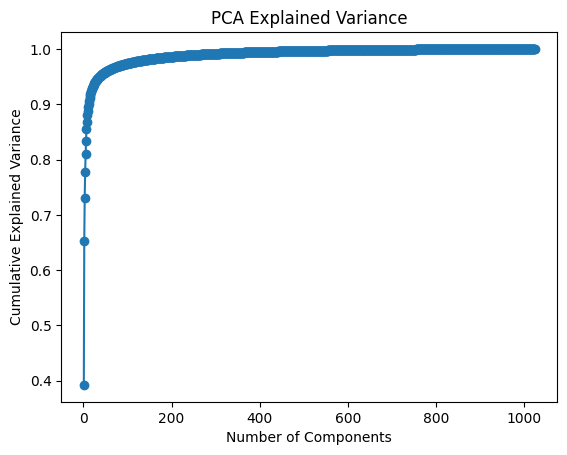

In [18]:
# use PCA (principle component analysis) to understand data variance and decide on the number of components to use for ICA
pca = PCA(n_components=None)  # All components
pca.fit(embedded_human_cells)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print(cumulative_variance)

plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.show()

In [19]:
# Decide n_components based on desired explained variance (e.g., 95%)
n_components_pca = np.argmax(cumulative_variance >= 0.95) + 1  # e.g., 95% of variance
print(f"Number of components to explain 95% variance: {n_components_pca}")

Number of components to explain 95% variance: 37


In [20]:
# use number of pca components to initialize Fast ICA object 
n_components = n_components_pca  

# create FastICA (independent component analysis) object with increased max_iter (default = 200) and tolerance (default = 0.0001)
ica = FastICA(n_components=n_components, max_iter=500, tol=0.001) 
# fit and transform human and mouse embeddings
human_ica = ica.fit_transform(embedded_human_cells)
mouse_ica = ica.fit_transform(embedded_mouse_cells) 

print("Human ICA shape:", human_ica.shape)
print("Mouse ICA shape:", mouse_ica.shape)

Human ICA shape: (8569, 37)
Mouse ICA shape: (1886, 37)


In [21]:
# create AnnData objects from the ICA-transformed embeddings
human_adata = anndata.AnnData(human_ica, obs=human_restricted.obs)
mouse_adata = anndata.AnnData(mouse_ica, obs=mouse_restricted.obs)

# Add species labels
human_adata.obs['species'] = 'human'
mouse_adata.obs['species'] = 'mouse'

human_adata.obs['cell_type'] = [x.lower() for x in human_adata.obs['cell_type']]
mouse_adata.obs['cell_type'] = [x.lower() for x in mouse_adata.obs['cell_type']]

# Before running CINEMA-OT, process the data to handle potential issues
def preprocess_for_ot(adata):
    nonzero_rows = np.sum(adata.X != 0, axis=1) > 0
    nonzero_cols = np.sum(adata.X != 0, axis=0) > 0
    adata = adata[nonzero_rows, :][:, nonzero_cols]
    return adata

# Preprocess combined_adata to ensure valid transport matrix
human_adata = preprocess_for_ot(human_adata)
mouse_adata = preprocess_for_ot(mouse_adata)

# Run PCA on data and store the result in obsm
sc.pp.pca(human_adata)
print(f"PCA shape: {human_adata.obsm['X_pca'].shape}")

sc.pp.pca(mouse_adata)
print(f"PCA shape: {mouse_adata.obsm['X_pca'].shape}")

PCA shape: (8569, 36)
PCA shape: (1886, 36)


In [22]:
# Combine the datasets to perform OT
combined_adata = anndata.concat([human_adata, mouse_adata], merge='same')

# Run PCA on the combined AnnData
sc.pp.pca(combined_adata)

In [23]:
# Sample dataset sizes
num_human_cells = human_adata.obsm['X_pca'].shape[0]
print(f"Number of human cells: {num_human_cells}")

num_mouse_cells = mouse_adata.obsm['X_pca'].shape[0]
print(f"Number of mouse cells: {num_mouse_cells}")

# Handle cell number imbalances with weight adjustments
human_weight = num_mouse_cells / num_human_cells
mouse_weight = 1  # weights can be normalized to sum up to 1

# Extracting species label to adjust weights accordingly
weights = np.where(combined_adata.obs['species'] == 'human', human_weight, mouse_weight)

# Adding weights to combined_adata
combined_adata.obs['weights'] = weights

Number of human cells: 8569
Number of mouse cells: 1886


In [24]:
# Run CINEMA-OT
cf, ot_matrix, de, r = co.cinemaot.cinemaot_weighted(
    adata=combined_adata,
    obs_label='species',   # Column indicating species
    ref_label='human',     # Reference species
    expr_label='mouse',    # Experimental species
    use_rep='X_pca',       # Use PCA representation
    dim=20,                # Number of independent components
    thres=0.75,            # Adjust threshold based on empirical results
    smoothness=1e-4,       # Adjusting smoothness; try smaller if too smooth
    eps=1e-3,              # Regularization strength; smaller for finer details
    k=10,                  # Number of neighbors for k-NN
    resolution=1,          # Resolution for leiden clustering
    mode='parametric'      # Mode for differential expression analysis
)

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


In [25]:
# Display results
print("Confounder (cf) shape:", cf.shape)
print("Optimal Transport (ot) shape:", ot_matrix.shape)
print("Differential Expression (de) shape:", de.shape)
print("Weights for expr condition (r):", r)

Confounder (cf) shape: (10455, 20)
Optimal Transport (ot) shape: (8569, 837)
Differential Expression (de) shape: (8569, 37)
Weights for expr condition (r): [0.08901099 0.08901099 0.08901099 ... 0.09968847 0.09968847 0.08901099]


In [26]:
ot_matrix

array([[2.21868513e-08, 1.02303299e-10, 1.65444993e-09, ...,
        6.62603810e-11, 2.86876438e-06, 2.38044231e-08],
       [3.63640882e-08, 4.84032402e-10, 8.62463822e-10, ...,
        1.24019805e-09, 1.98553378e-07, 1.99323359e-08],
       [1.47994859e-08, 1.56481169e-09, 1.23668018e-08, ...,
        8.26076795e-09, 2.66758223e-08, 4.42767209e-09],
       ...,
       [1.37603926e-06, 4.57490266e-10, 1.00266535e-08, ...,
        7.97593601e-10, 6.73466222e-08, 1.24713532e-07],
       [7.57763781e-07, 1.31728180e-08, 7.59115630e-07, ...,
        2.03356610e-10, 4.58287987e-09, 2.50066719e-08],
       [1.07531615e-10, 6.30421749e-09, 1.63719879e-08, ...,
        5.51170252e-10, 1.09698652e-10, 5.75057570e-12]])

In [27]:
# Extract paired indices based on the optimal transport plan
paired_indices = []
for human_idx in range(ot_matrix.shape[0]):
    if np.sum(ot_matrix[human_idx]) > 0:
        mouse_idx = np.argmax(ot_matrix[human_idx])
        paired_indices.append((human_idx, mouse_idx))

In [28]:
if not np.isnan(ot_matrix).any():
    # Extract paired indices based on the optimal transport plan
    paired_indices = []
    for human_idx in range(ot_matrix.shape[0]):
        if np.sum(ot_matrix[human_idx]) > 0:
            mouse_idx = np.argmax(ot_matrix[human_idx])
            paired_indices.append((human_idx, mouse_idx))

    # Print paired indices
    print("Optimal Transport Pairs (human_idx, mouse_idx):")
    for human_idx, mouse_idx in paired_indices:
        print(f"Human cell {human_idx} paired with Mouse cell {mouse_idx}")


Optimal Transport Pairs (human_idx, mouse_idx):
Human cell 0 paired with Mouse cell 686
Human cell 1 paired with Mouse cell 798
Human cell 2 paired with Mouse cell 539
Human cell 3 paired with Mouse cell 539
Human cell 4 paired with Mouse cell 326
Human cell 5 paired with Mouse cell 614
Human cell 6 paired with Mouse cell 170
Human cell 7 paired with Mouse cell 311
Human cell 8 paired with Mouse cell 329
Human cell 9 paired with Mouse cell 309
Human cell 10 paired with Mouse cell 707
Human cell 11 paired with Mouse cell 541
Human cell 12 paired with Mouse cell 581
Human cell 13 paired with Mouse cell 478
Human cell 14 paired with Mouse cell 128
Human cell 15 paired with Mouse cell 612
Human cell 16 paired with Mouse cell 517
Human cell 17 paired with Mouse cell 800
Human cell 18 paired with Mouse cell 722
Human cell 19 paired with Mouse cell 126
Human cell 20 paired with Mouse cell 547
Human cell 21 paired with Mouse cell 42
Human cell 22 paired with Mouse cell 195
Human cell 23 paired

In [29]:
# Create the "plots" directory if it doesn't exist
plots_dir = "plots"
os.makedirs(plots_dir, exist_ok=True)

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


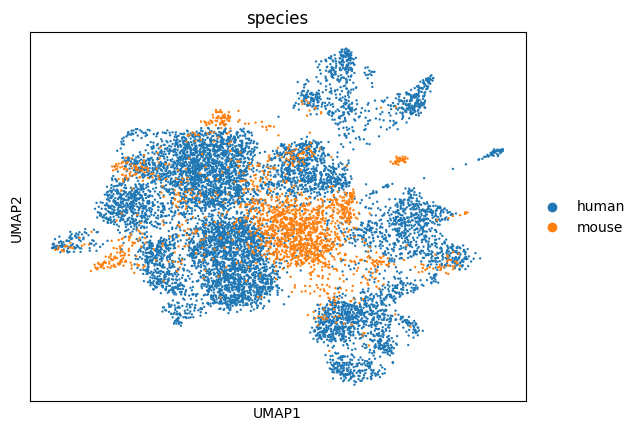

UMAP plot saved to plots/umap_species.png


In [30]:
# Optional: Visualize the optimal transport pairs on UMAP
sc.pp.neighbors(combined_adata, use_rep='X_pca')
sc.tl.umap(combined_adata)
combined_adata.obsm['cf'] = cf

# Visualize UMAP
umap_species_plot_path = os.path.join(plots_dir, "umap_species.png")
fig = sc.pl.umap(combined_adata, color=['species'], return_fig=True)
plt.show()

# Save the plot using matplotlib
fig.savefig(umap_species_plot_path, dpi=300, bbox_inches='tight')
plt.close()  # Close the plot to free memory

# Print confirmation
print(f"UMAP plot saved to {umap_species_plot_path}")


/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


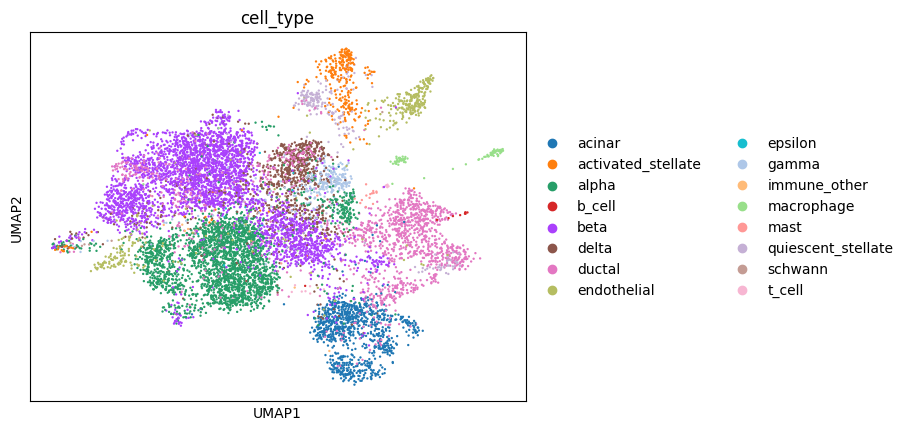

UMAP plot saved to plots/umap_cell_type.png


In [31]:

# Optional: Visualize the optimal transport pairs on UMAP
sc.pp.neighbors(combined_adata, use_rep='X_pca')
sc.tl.umap(combined_adata)
combined_adata.obsm['cf'] = cf

# Visualize UMAP
umap_cell_type_plot_path = os.path.join(plots_dir, "umap_cell_type.png")
fig = sc.pl.umap(combined_adata, color=['cell_type'], return_fig=True)
plt.show()

# Save the plot using matplotlib
fig.savefig(umap_cell_type_plot_path, dpi=300, bbox_inches='tight')
plt.close()  # Close the plot to free memory

# Print confirmation
print(f"UMAP plot saved to {umap_cell_type_plot_path}")

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


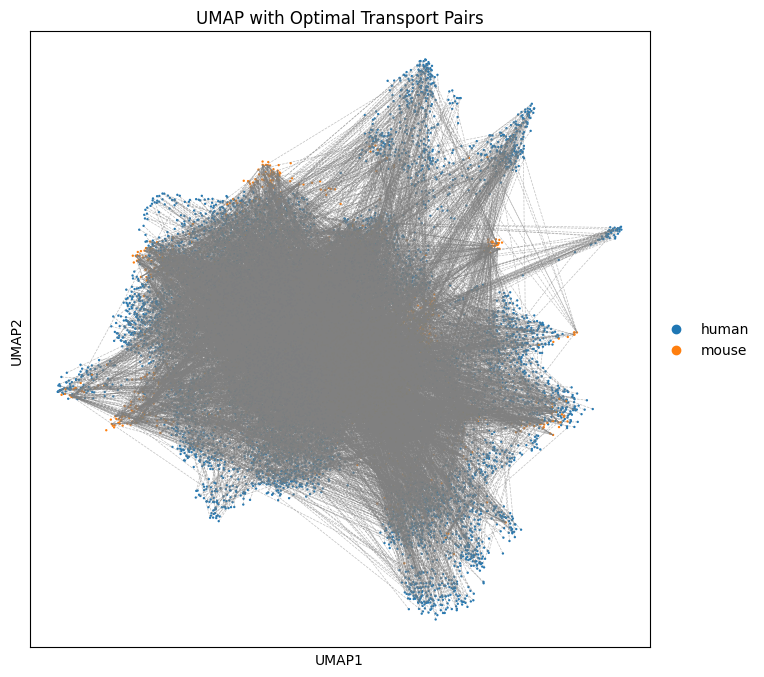

UMAP plot saved to plots/umap_ot_pair_species.png


In [32]:
# Optional: Plot optimal transport pairs
fig, ax = plt.subplots(figsize=(8, 8))
sc.pl.umap(combined_adata, color=['species'], ax=ax, show=False)
for human_idx in range(ot_matrix.shape[0]):
    if np.sum(ot_matrix[human_idx]) > 0:
        mouse_idx = np.argmax(ot_matrix[human_idx])
        h = combined_adata.obsm['X_umap'][human_idx, :]
        m = combined_adata.obsm['X_umap'][mouse_idx + human_adata.shape[0], :]
        plt.plot([h[0], m[0]], [h[1], m[1]], color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
plt.title('UMAP with Optimal Transport Pairs')
plt.show()

umap_ot_pair_species_path = os.path.join(plots_dir, "umap_ot_pair_species.png")
# Save the plot using matplotlib
fig.savefig(umap_ot_pair_species_path, dpi=300, bbox_inches='tight')
plt.close()  # Close the plot to free memory

# Print confirmation
print(f"UMAP plot saved to {umap_ot_pair_species_path}")

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


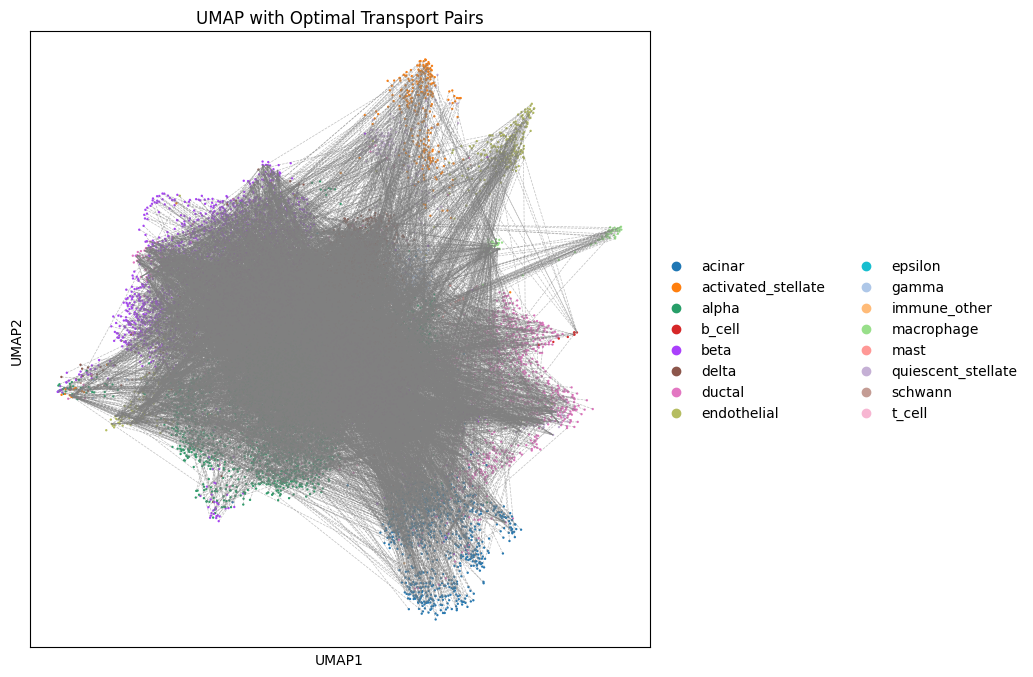

UMAP plot saved to plots/umap_ot_pair_cell_type.png


In [33]:
# Optional: Plot optimal transport pairs
fig, ax = plt.subplots(figsize=(8, 8))
sc.pl.umap(combined_adata, color=['cell_type'], ax=ax, show=False)
for human_idx in range(ot_matrix.shape[0]):
    if np.sum(ot_matrix[human_idx]) > 0:
        mouse_idx = np.argmax(ot_matrix[human_idx])
        h = combined_adata.obsm['X_umap'][human_idx, :]
        m = combined_adata.obsm['X_umap'][mouse_idx + human_adata.shape[0], :]
        plt.plot([h[0], m[0]], [h[1], m[1]], color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
plt.title('UMAP with Optimal Transport Pairs')
plt.show()

umap_ot_pair_cell_type_path = os.path.join(plots_dir, "umap_ot_pair_cell_type.png")
# Save the plot using matplotlib
fig.savefig(umap_ot_pair_cell_type_path, dpi=300, bbox_inches='tight')
plt.close()  # Close the plot to free memory

# Print confirmation
print(f"UMAP plot saved to {umap_ot_pair_cell_type_path}")

In [34]:
# Extract true labels
human_labels = [x.lower() for x in human_adata.obs['cell_type'].values]
mouse_labels = [x.lower() for x in mouse_adata.obs['cell_type'].values]

# Create lists of labels based on paired indices
paired_human_labels = [human_labels[p[0]] for p in paired_indices]
paired_mouse_labels = [mouse_labels[p[1]] for p in paired_indices]

# Ensure both label sets are consistent but separated by species
unique_human_labels = np.unique(human_labels)
unique_mouse_labels = np.unique(mouse_labels)
print("Unique human labels:", unique_human_labels)
print("Unique mouse labels:", unique_mouse_labels)

# Combine unique labels for human and mouse separately
all_labels = np.union1d(unique_human_labels, unique_mouse_labels)

Unique human labels: ['acinar' 'activated_stellate' 'alpha' 'beta' 'delta' 'ductal'
 'endothelial' 'epsilon' 'gamma' 'macrophage' 'mast' 'quiescent_stellate'
 'schwann' 't_cell']
Unique mouse labels: ['activated_stellate' 'alpha' 'b_cell' 'beta' 'delta' 'ductal'
 'endothelial' 'gamma' 'immune_other' 'macrophage' 'quiescent_stellate'
 'schwann' 't_cell']


In [35]:
same_cell_type = [x for x in all_labels if x in unique_human_labels and x in unique_mouse_labels]
print("Shared cell types in human and mice:", same_cell_type)

Shared cell types in human and mice: ['activated_stellate', 'alpha', 'beta', 'delta', 'ductal', 'endothelial', 'gamma', 'macrophage', 'quiescent_stellate', 'schwann', 't_cell']


In [43]:
# Generate confusion matrix with consistent labels
cm = confusion_matrix(paired_human_labels, paired_mouse_labels, labels=all_labels)

# Convert to DataFrame for better visualization
cm_df = DataFrame(cm, index=all_labels, columns=all_labels)

# Define file path for the heatmap plot
confusion_matrix_cinemaot_path = os.path.join(plots_dir, "confusion_matrix_cinemaot.png")

# Create a matplotlib figure and axis
plt.figure(figsize=(12, 10))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix of Human-Mouse Cell Pairs')
plt.xlabel('Mouse Cell Types')
plt.ylabel('Human Cell Types')

# Save the plot using matplotlib
plt.savefig(confusion_matrix_cinemaot_path, dpi=300, bbox_inches='tight')
plt.close()  # Close the plot to free memory

# Print confirmation
print(f"Confusion matrix plot saved to {confusion_matrix_cinemaot_path}")


Confusion matrix plot saved to plots/confusion_matrix_cinemaot.png


In [44]:
# Define the shared cell types
shared_cell_types = [x for x in all_labels if (x in unique_human_labels) and (x in unique_mouse_labels)]

# Filter the paired indices to include only those with shared cell types
filtered_paired_indices = [(phl, pml) for phl, pml in zip(paired_human_labels, paired_mouse_labels) if phl in shared_cell_types and pml in shared_cell_types]

# Extract filtered human and mouse labels
filtered_paired_human_labels = [phl for phl, pml in filtered_paired_indices]
filtered_paired_mouse_labels = [pml for phl, pml in filtered_paired_indices]

# Ensure both label sets are consistent but separated by species
unique_human_labels = np.unique(filtered_paired_human_labels)
unique_mouse_labels = np.unique(filtered_paired_mouse_labels)
print("Unique human labels:", unique_human_labels)
print("Unique mouse labels:", unique_mouse_labels)

# Generate the confusion matrix with consistent labels
cm_same_cell = confusion_matrix(filtered_paired_human_labels, filtered_paired_mouse_labels, labels=shared_cell_types)

# Convert to DataFrame for better visualization
cm_df_same_cell = DataFrame(cm_same_cell, index=shared_cell_types, columns=shared_cell_types)

# Define file path for the heatmap plot
confusion_matrix_same_cells_cinemaot_path = os.path.join(plots_dir, "confusion_matrix_same_cells_cinemaot.png")

# Plot confusion matrix using seaborn
plt.figure(figsize=(12, 10))
ax = sns.heatmap(cm_df_same_cell, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix of Human-Mouse Cell Pairs (Shared Cell Types)')
plt.xlabel('Mouse Cell Types')
plt.ylabel('Human Cell Types')

# Save the plot using matplotlib
plt.savefig(confusion_matrix_same_cells_cinemaot_path, dpi=300, bbox_inches='tight')
plt.close()  # Close the plot to free memory

# Print confirmation
print(f"Confusion matrix plot saved to {confusion_matrix_same_cells_cinemaot_path}")

Unique human labels: ['activated_stellate' 'alpha' 'beta' 'delta' 'ductal' 'endothelial'
 'gamma' 'macrophage' 'quiescent_stellate' 'schwann' 't_cell']
Unique mouse labels: ['activated_stellate' 'alpha' 'beta' 'delta' 'ductal' 'endothelial'
 'gamma' 'macrophage' 'quiescent_stellate' 'schwann' 't_cell']
Confusion matrix plot saved to plots/confusion_matrix_same_cells_cinemaot.png


In [45]:
all_cell_types = [
    'acinar', 'activated_stellate', 'alpha', 'b_cell', 'beta', 'delta', 'ductal', 
    'endothelial', 'epsilon', 'gamma', 'immune_other', 'macrophage', 'mast', 
    'quiescent_stellate', 'schwann', 't_cell'
]

# Initialize similarity matrix with zeros
similarity_matrix = pd.DataFrame(
    np.zeros((len(all_cell_types), len(all_cell_types))),
    index=all_cell_types,
    columns=all_cell_types
)

# Assign known similarities
similarity_matrix.loc['beta', 'delta'] = 0.7
similarity_matrix.loc['delta', 'beta'] = 0.7
similarity_matrix.loc['alpha', 'beta'] = 0.6
similarity_matrix.loc['beta', 'alpha'] = 0.6
similarity_matrix.loc['ductal', 'endothelial'] = 0.5
similarity_matrix.loc['endothelial', 'ductal'] = 0.5

# Alpha and delta cells are from the same tissue context
similarity_matrix.loc['alpha', 'delta'] = 0.5
similarity_matrix.loc['delta', 'alpha'] = 0.5

# Acinar and ductal cells are from the same tissue context (exocrine pancreas)
similarity_matrix.loc['acinar', 'ductal'] = 0.4
similarity_matrix.loc['ductal', 'acinar'] = 0.4

# Endothelial cells should have some general similarity across different cell types in circulatory system
similarity_matrix.loc['endothelial', 'macrophage'] = 0.3
similarity_matrix.loc['macrophage', 'endothelial'] = 0.3

# Quiescent and activated stellate similarity
similarity_matrix.loc['quiescent_stellate', 'activated_stellate'] = 0.6
similarity_matrix.loc['activated_stellate', 'quiescent_stellate'] = 0.6

# Activated stellate and macrophages showing some tissue remodeling and inflammation contexts
similarity_matrix.loc['activated_stellate', 'macrophage'] = 0.4
similarity_matrix.loc['macrophage', 'activated_stellate'] = 0.4

# The rest are zeros indicating no assumed similarity
print(similarity_matrix)

                    acinar  activated_stellate  alpha  b_cell  beta  delta  \
acinar                 0.0                 0.0    0.0     0.0   0.0    0.0   
activated_stellate     0.0                 0.0    0.0     0.0   0.0    0.0   
alpha                  0.0                 0.0    0.0     0.0   0.6    0.5   
b_cell                 0.0                 0.0    0.0     0.0   0.0    0.0   
beta                   0.0                 0.0    0.6     0.0   0.0    0.7   
delta                  0.0                 0.0    0.5     0.0   0.7    0.0   
ductal                 0.4                 0.0    0.0     0.0   0.0    0.0   
endothelial            0.0                 0.0    0.0     0.0   0.0    0.0   
epsilon                0.0                 0.0    0.0     0.0   0.0    0.0   
gamma                  0.0                 0.0    0.0     0.0   0.0    0.0   
immune_other           0.0                 0.0    0.0     0.0   0.0    0.0   
macrophage             0.0                 0.4    0.0     0.0   

In [46]:

# Generate scores based on confusion matrix and similarity matrix 

# Calculate weighted score
weighted_score = 0
for human_cell in all_cell_types:
    for mouse_cell in all_cell_types:
        count = cm_df.loc[human_cell, mouse_cell]
        sim_score = similarity_matrix.loc[human_cell, mouse_cell]
        weighted_score += count * sim_score

# Normalize by the maximum possible score
max_possible_score = cm_df.sum().sum()  # Total number of pairings
normalized_score = weighted_score / max_possible_score

# Print scores
print(f"Weighted Score: {weighted_score:.2f}")
print(f"Normalized Score: {normalized_score:.4f}")

Weighted Score: 1086.00
Normalized Score: 0.1267
